# About this Notebook

This notebook should work whenever the FOM depends on two variables (t, x) and whenever the initial condition parameter vector, $\theta$, has two elements (there are two parameters). If your example does not fall into that category, use another notebook!

# Training 

First, let us train a higher-order LaSDI model on the Burgers' equation data. 
If you want to load a pre-trained model from a save, go to the next cell. 

13:16:34.785 - Initialize:Initialize_Trainer:109 - INFO - Initializing Trainer (gplasdi)
13:16:34.785 - Initialize:Initialize_Trainer:109 - INFO - Initializing Trainer (gplasdi)
13:16:34.786 - ParameterSpace:__init__:174 - INFO - Initializing a ParameterSpace object with parameters ['a', 'w']
13:16:34.786 - ParameterSpace:__init__:174 - INFO - Initializing a ParameterSpace object with parameters ['a', 'w']
13:16:34.787 - ParameterSpace:__init__:182 - INFO - The testing set has 25 parameter combinations
13:16:34.787 - ParameterSpace:__init__:182 - INFO - The testing set has 25 parameter combinations
13:16:34.787 - ParameterSpace:__init__:189 - INFO - The training set has 4 parameter combinations
13:16:34.787 - ParameterSpace:__init__:189 - INFO - The training set has 4 parameter combinations
13:16:34.788 - Initialize:Initialize_Physics:249 - INFO - Initializing Physics (BurgersSecondOrder)
13:16:34.788 - Initialize:Initialize_Physics:249 - INFO - Initializing Physics (BurgersSecondOrder

Function name      	Calls	Total time	Time/call

Rollout Setup      	802	1.403e+00	1.749e-03

train_step         	200	1.928e+01	9.642e-02

Forward Pass       	800	2.398e+00	2.998e-03

Reconstruction Loss	800	3.175e-01	3.968e-04

Consistency Loss   	800	7.675e-01	9.594e-04

Chain Rule Loss    	800	3.285e+00	4.106e-03

Calibration        	200	3.367e-01	1.683e-03

Rollout Loss       	200	1.998e+00	9.989e-03

Backwards Pass     	200	8.418e+00	4.209e-02

Report             	200	1.662e-01	8.308e-04

finalize           	1	2.956e-03	2.956e-03

Plotting testing parameter combination number 10 (['a', 'w'] = [0.8 0.9])


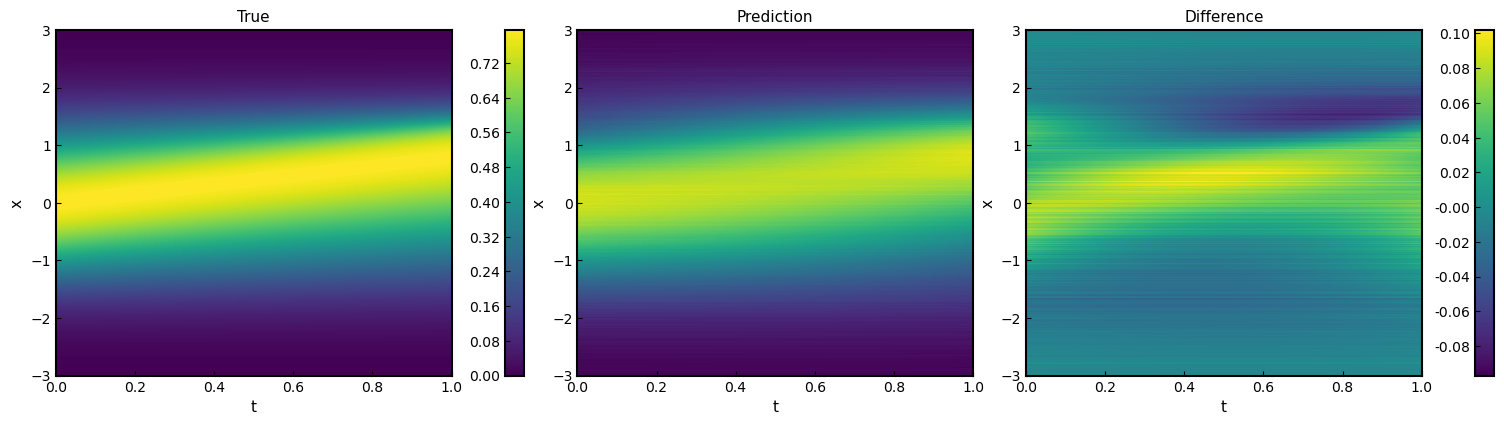

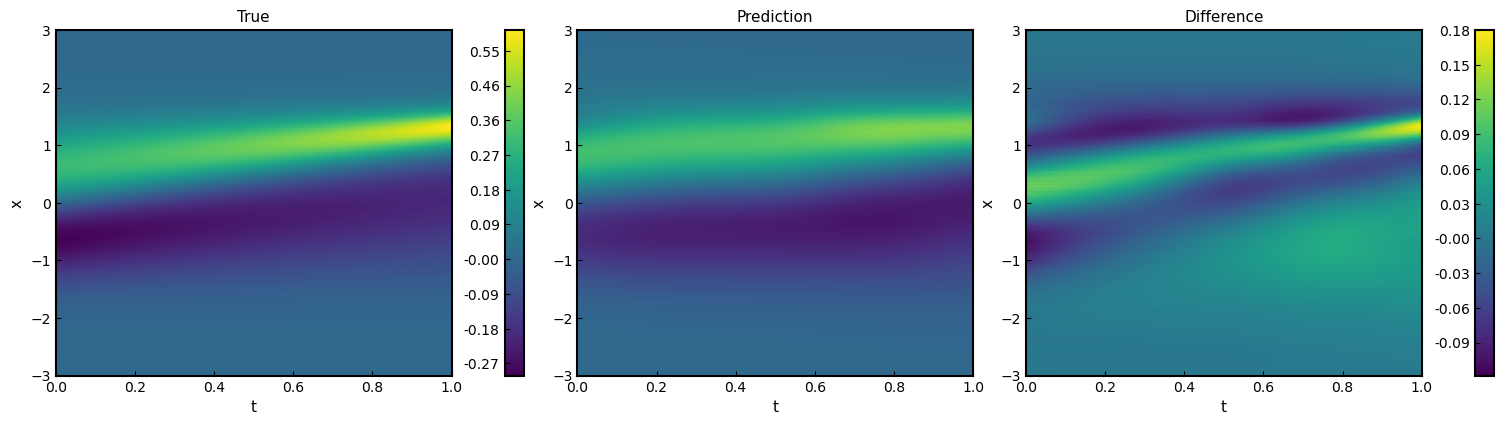

13:17:05.186 - GPLaSDI:get_new_sample_point:853 - INFO - 
~~~~~~~ Finding New Point ~~~~~~~
13:17:05.186 - GPLaSDI:get_new_sample_point:853 - INFO - 
~~~~~~~ Finding New Point ~~~~~~~
/Users/stephany1/Documents/Projects/Second Order LaSDI/src/GPLaSDI.py:861: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where yo

Function name      	Calls	Total time	Time/call

Rollout Setup      	1805	3.535e+00	1.959e-03

train_step         	400	4.557e+01	1.139e-01

Forward Pass       	1800	5.706e+00	3.170e-03

Reconstruction Loss	1800	7.559e-01	4.200e-04

Consistency Loss   	1800	1.779e+00	9.881e-04

Chain Rule Loss    	1800	7.565e+00	4.203e-03

Calibration        	400	7.714e-01	1.929e-03

Rollout Loss       	400	5.238e+00	1.310e-02

Backwards Pass     	400	1.943e+01	4.858e-02

Report             	400	3.559e-01	8.897e-04

finalize           	2	5.816e-03	2.908e-03

new_sample         	1	1.142e+01	1.142e+01



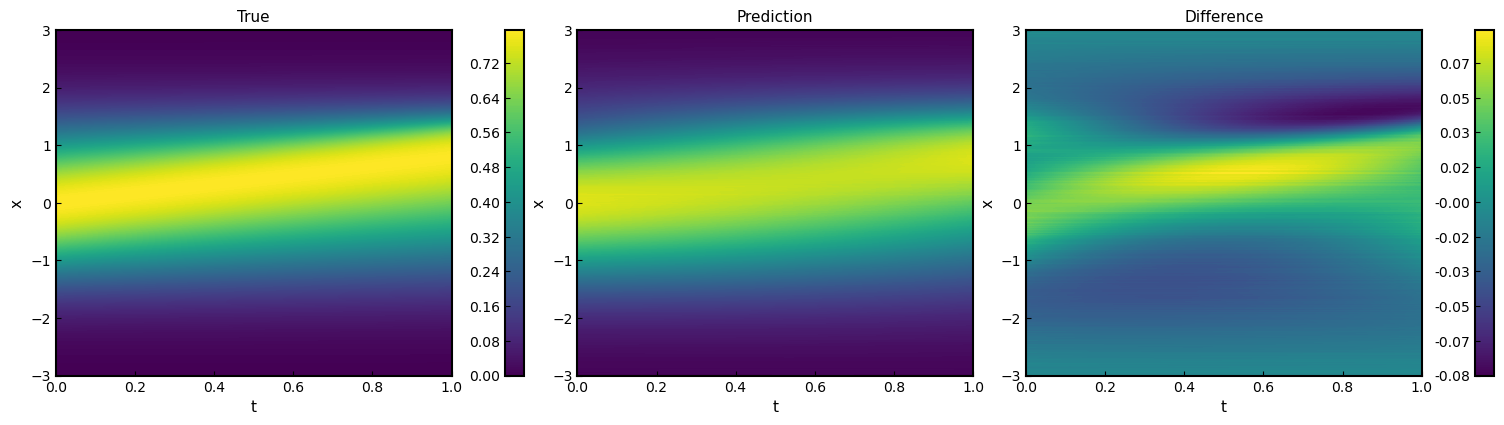

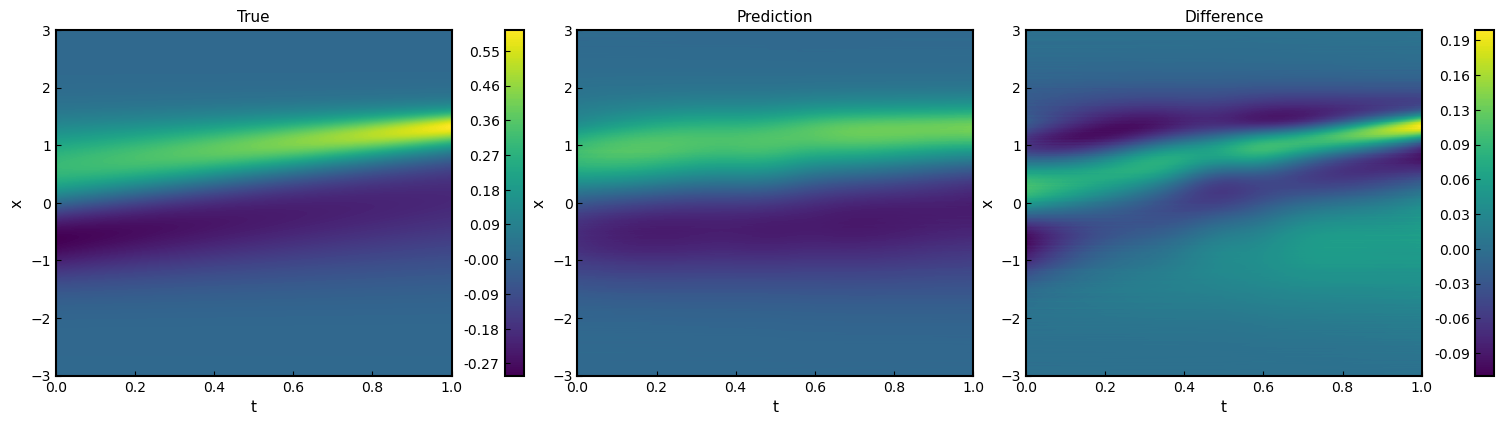

In [1]:
# -------------------------------------------------------------------------------------------------
# Imports 
# -------------------------------------------------------------------------------------------------

import  os;
import  sys;

src_path    : str = os.path.join(os.path.abspath(os.path.pardir), "src");
utils_path  : str = os.path.join(src_path, "Utilities");
sys.path.append(src_path);
sys.path.append(utils_path);

import  random;
import  yaml;
import  logging;

import  torch
import  numpy;

from    Workflow    import  Save;
from    Enums       import  NextStep, Result
from    Sample      import  Run_Samples, Update_Train_Space;
from    Initialize  import  Initialize_Trainer;
from    Logging     import  Initialize_Logger, Log_Dictionary;
from    Plot        import  Plot_Reconstruction;



# -------------------------------------------------------------------------------------------------
# Setup
# -------------------------------------------------------------------------------------------------

# Set up the logger
Initialize_Logger(logging.INFO);
LOGGER  : logging.Logger    = logging.getLogger(__name__);

# Load the configuration.
cfg_file : str = 'burgers.yml';
#cfg_file : str = 'explicit.yml';
with open(cfg_file, 'r') as f:
    config : dict = yaml.safe_load(f);
Log_Dictionary(LOGGER = LOGGER, D = config, level = logging.DEBUG);

# Setup the trainer
trainer, param_space, physics, model, latent_dynamics = Initialize_Trainer(config);



# -------------------------------------------------------------------------------------------------
# Train
# -------------------------------------------------------------------------------------------------

LOGGER.info("Training with %d epochs" % trainer.max_iter);

# generate initial training/test data
Update_Train_Space(trainer, config);
Run_Samples(trainer, config);



# Fetch the number of testing, training examples.
n_train : int   = param_space.n_train();
n_test  : int   = param_space.n_test();
n_IC    : int   = latent_dynamics.n_IC;

# initial training given training data
trainer.train();


# Select a random parameter combination to investigate.
index_plot  : int = random.randrange(0, n_test);
print("Plotting testing parameter combination number %d (%s = %s)" % (index_plot, str(param_space.param_names), str(param_space.test_space[index_plot, :])));

Plot_Reconstruction(
    X_True  = trainer.X_Test[index_plot],
    model   = trainer.model, 
    t_grid  = trainer.t_Test[index_plot].numpy(), 
    x_grid  = trainer.physics.X_Positions);


while (trainer.restart_iter < trainer.max_iter):
    if (trainer.restart_iter <= trainer.max_greedy_iter):
        # perform greedy sampling to pick up new samples
        Update_Train_Space(trainer, config);
        # update training data with newly picked samples
        Run_Samples(trainer, config);

    # train over given training data
    trainer.train();

    # Plot 
    Plot_Reconstruction(  
        X_True  = trainer.X_Test[index_plot],
        model   = trainer.model, 
        t_grid  = trainer.t_Test[index_plot].numpy(), 
        x_grid  = trainer.physics.X_Positions);


# Finally, save!
Save(   param_space         = param_space, 
        physics             = physics, 
        model               = model, 
        latent_dynamics     = latent_dynamics, 
        trainer             = trainer, 
        next_step           = NextStep.PickSample, 
        result              = Result.Success,
        restart_filename    = None);

# Loading From a Save


If you instead want to load a saved model, we can load the restart file for post-training.

In [ ]:
# Add src directory to the search path
import  os;
import  sys;
src_path    : str = os.path.join(os.path.abspath(os.path.pardir), "src");
sys.path.append(src_path);

import  yaml;
import  logging;

import  numpy; 
import  torch;

from    ParameterSpace  import  ParameterSpace;
from    Initialize      import  Initialize_Trainer;



# Specify the restart file you have.
filename    : str   =  'lasdi_02_21_2025_15_57.npy'
cfg_file    : str   = 'burgers.yml'
with open(cfg_file, 'r') as f:
    config = yaml.safe_load(f)

file_path   : str   = os.path.join(os.path.join(os.path.pardir, "results"), filename);
restart_file = numpy.load(file_path, allow_pickle = True).item()

trainer, param_space, physics, model, latent_dynamics = Initialize_Trainer(config, restart_file)

FileNotFoundError: [Errno 2] No such file or directory: 'burgers1d.yml'

# Post-processing

Setup data for post-processing:

In [2]:
n_coef          : int                       = latent_dynamics.n_coefs;
n_IC            : int                       = latent_dynamics.n_IC; 
n_p             : int                       = param_space.n_p; 

coefs           : numpy.ndarray             = trainer.best_coefs;           # shape = (n_train, n_coefs).
X_Train         : list[list[torch.Tensor]]  = trainer.X_Train;              # len = n_train. i'th element is a list of length n_IC. j'th element has length (n_t(i), n_x); holds j'th derivative of i'th FOM train solve
X_Test          : list[list[torch.Tensor]]  = trainer.X_Test;               # len = n_test. i'th element is a list of length n_IC. j'th element has length (n_t(i), n_x); holds j'th derivative of i'th FOM test solve.
t_Train         : list[torch.Tensor]        = trainer.t_Train;              # len = n_train. i'th element is a numpy.ndarray of shape (n_t(i)) whose j'th element holds the j'th time value for the i'th FOM train solve.
t_Test          : list[torch.Tensor]        = trainer.t_Test;               # len = n_test. i'th element is a numpy.ndarray of shape (n_t(i)) whose j'th element holds the j'th time value for the i'th FOM test solve.
n_samples       : int                       = trainer.n_samples;

param_train     : numpy.ndarray             = param_space.train_space;      # shape = (n_train, n_p)
param_test      : numpy.ndarray             = param_space.test_space;       # shape = (n_test, n_p)
param_names     : list[str]                 = param_space.param_names;

test_meshgrid   : tuple[numpy.ndarray]      = param_space.test_meshgrid;    # len = n_p. i'th element is meshgrid for i'th parameter.
test_grid_sizes : list[int]                 = param_space.test_grid_sizes;  # len = n_p. i'th element holds the number of values of the i'th parameter in the test set.
n_init_train    : int                       = param_space.n_init_train;     # The initial number of combinations of parameters in the training set.
n_train         : int                       = param_space.n_train();
n_test          : int                       = param_space.n_test();

X_Positions     : numpy.ndarray             = physics.X_Positions;          # Spatial discretization of FOM problem domain.
assert(X_Positions.ndim == 1);


## Gaussian-process uncertainty evaluation
For each combination of parameters, evaluate the coefficient GPs to generate a set of coefficients for the latent dynamics for that parameter combination. Then solve each latent dynamics forward in time.

In [3]:
# First, we need to import a few new things.
import os;
import sys;
physics_path    : str   = os.path.join(os.path.join(os.path.pardir, "src"), "Physics");
utils_path      : str   = os.path.join(os.path.join(os.path.pardir, "src"), "Utilities");
sys.path.append(physics_path);

from    sklearn.gaussian_process    import  GaussianProcessRegressor;

import  SolveROMs;
import  GaussianProcess;
from    Physics                     import  Physics;
from    Model                       import  Autoencoder, Autoencoder_Pair;

# Setup
model.cpu();



# Get a GP for each coefficient in the latent dynamics.
gp_list         : list[GaussianProcessRegressor]    = GaussianProcess.fit_gps(param_space.train_space, coefs);

Zis_samples     : list[list[numpy.ndarray]] = SolveROMs.sample_roms(model, physics, latent_dynamics, gp_list, param_test, t_Test, n_samples);    # len = n_test. i'th element is an n_IC element list whose j'th element has shape (n_t(i), n_samples, n_z)
Zis_mean        : list[list[numpy.ndarray]] = SolveROMs.average_rom(model, physics, latent_dynamics, gp_list, param_test, t_Test);               # len = n_test. i'th element is an n_IC element list whose j'th element has shape (n_t(i), n_z)


/Users/stephany1/miniconda3/envs/LaSDI/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/stephany1/miniconda3/envs/LaSDI/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/stephany1/miniconda3/envs/LaSDI/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/stephany1/mi

Now, decode the latent trajectories and compare them to the test set. Use these values to compute some errors. 

In [4]:
# Set up arrays to hold the average error between X_pred_mean and X_test, as well as the std of 
# the predictions.
mean_rel_error   : list[numpy.ndarray]   = [];
max_std          : list[numpy.ndarray]   = [];
for d in range(n_IC):
    mean_rel_error.append(  numpy.zeros(n_test, dtype = numpy.float32));
    max_std.append(         numpy.zeros(n_test, dtype = numpy.float32));



# Pass the samples through the decoder. The way this works depends on what kind of model we are using. 
if(isinstance(model, Autoencoder)):
    # Decode the mean predictions.
    X_pred_mean     : list[numpy.ndarray]   = [model.Decode(torch.Tensor(Zis_mean[0])).detach().numpy()];  # shape = (n_test, n_t, n_x)

    # Decode the Zis for each parameter. Note that the decoder expects a 3d tensor of shape 
    # (n_test, n_t, n_z). We can somewhat abuse this by treating the different samples as different 
    # parameters. We still need to loop over the number of parameters, however.
    for i in range(n_test):
        ith_Disp_Pred   : numpy.ndarray =  model.Decode(torch.Tensor(Zis_samples[i][0])).detach().numpy();
        max_std[0][i]                   = ith_Disp_Pred.std(axis = 0).max();


elif(isinstance(model, Autoencoder_Pair)):
    # Decode the mean predictions.
    X_pred_mean     : list[list[numpy.ndarray]]     = [];   # len = n_test. i'th element has len n_IC whose j'th element has shape (n_t_i, n_x).
    for i in range(n_test):
        Disp_Pred_mean_i, Vel_Pred_mean_i   = model.Decode(torch.Tensor(Zis_mean[i][0]), torch.Tensor(Zis_mean[i][1]));
        X_pred_mean.append([Disp_Pred_mean_i.detach().numpy(), Vel_Pred_mean_i.detach().numpy()]);

    # Decode the Zis for each parameter and compute the corresponding STDs. 
    for i in range(n_test):
        # Decode the latent trajectories for each sample of the i'th combination of parameter values.
        n_t_i           : int                   = len(t_Test[i]);
        n_x             : int                   = len(X_Positions);

        ith_Disp_Pred   : numpy.ndarray         = numpy.empty((n_t_i, n_samples, n_x), dtype = numpy.float32);
        ith_Vel_Pred    : numpy.ndarray         = numpy.empty((n_t_i, n_samples, n_x), dtype = numpy.float32);

        for j in range(n_samples):
            Disp_Pred_ij, ith_Vel_Pred_ij       = model.Decode(torch.Tensor(Zis_samples[i][0][:, j, :]), torch.Tensor(Zis_samples[i][1][:, j, :]));
            ith_Disp_Pred[:, j, :]              = Disp_Pred_ij.detach().numpy();
            ith_Vel_Pred[:, j, :]               = ith_Vel_Pred_ij.detach().numpy();


        # Find the std of the frame of the position and velocity reconstruction with the i'th 
        # combination of parameter values that has the greatest variance.
        max_std[0][i]                   = ith_Disp_Pred.std(axis = 1).max();
        max_std[1][i]                   = ith_Vel_Pred.std(axis = 1).max();



# For each d \in {0, 1, ... , n_{IC} - 1} and k \in {1, 2, ... , n_test - 1}, find the mean 
# error between X_Pred_mean[d][k, ...] and X_test[d][k, ...].
for d in range(n_IC):
    for k in range(n_test):        
        # Extract the prediction, true values for the d'th component of the fom solution when we use 
        # the k'th parameter value. These have shape (n_t, n_x).
        kth_X_Pred_d            : numpy.ndarray = X_pred_mean[k][d];
        kth_X_Test_d            : numpy.ndarray = X_Test[k][d].numpy();
        
        # For each compute the relative error between the predicted and true values of the d'th 
        # derivative of the fom solution at each time step when we use the k'th combination of 
        # parameter values.
        kth_Relative_Errors_d   : numpy.ndarray = numpy.linalg.norm(kth_X_Pred_d - kth_X_Test_d, axis = 1) / numpy.linalg.norm(kth_X_Test_d, axis = 1);
        mean_rel_error[d][k]                    = kth_Relative_Errors_d.max();



# Get the mean and std of each coefficient's distribution when we evaluate the posterior coefficient 
# distributions at each testing parameter value. We then reshape these arrays to have shape 
# (N(1), ... , N(n_p)), where N(k) is the number of distinct values of the k'th parameter in the 
# training set. The i(1), ... , i(n_p), j element of the d'th element of these lists will hold the 
# mean and std of the distribution of the j'th parameter when we use the i(k)'th value of the k'th 
# parameter.
gp_pred_mean, gp_pred_std = GaussianProcess.eval_gp(gp_list, param_test);
gp_pred_mean    = gp_pred_mean.reshape(test_grid_sizes + [-1]);
gp_pred_std     = gp_pred_std.reshape(test_grid_sizes + [-1]);

# Reshape each element of mean_rel_error and max_std has shape (N(1), ... , N(n_p)), where N(k) 
# is the number of distinct values of the k'th parameter in the training set. The i(1), ... , i(n_p) 
# element of the d'th element of these lists will hold the mean error and std of the prediction of 
# the d'th derivative of the fom solution when we use the i(k)'th value of the k'th parameter, 
# respectively.
for d in range(n_IC):
    mean_rel_error[d]   = mean_rel_error[d].reshape(test_grid_sizes);
    max_std[d]          = max_std[d].reshape(test_grid_sizes);

# Visualization

Plot mean and standard deviation of coefficient matrix.
For SINDy of dimension 5, the coefficient matrix has a shape of (6, 5).

13:21:57.724 - Plot:Plot_GP2d:452 - INFO - Producing GP plots with 55 coefficients. The parameters are ['a', 'w']
13:21:57.724 - Plot:Plot_GP2d:452 - INFO - Producing GP plots with 55 coefficients. The parameters are ['a', 'w']


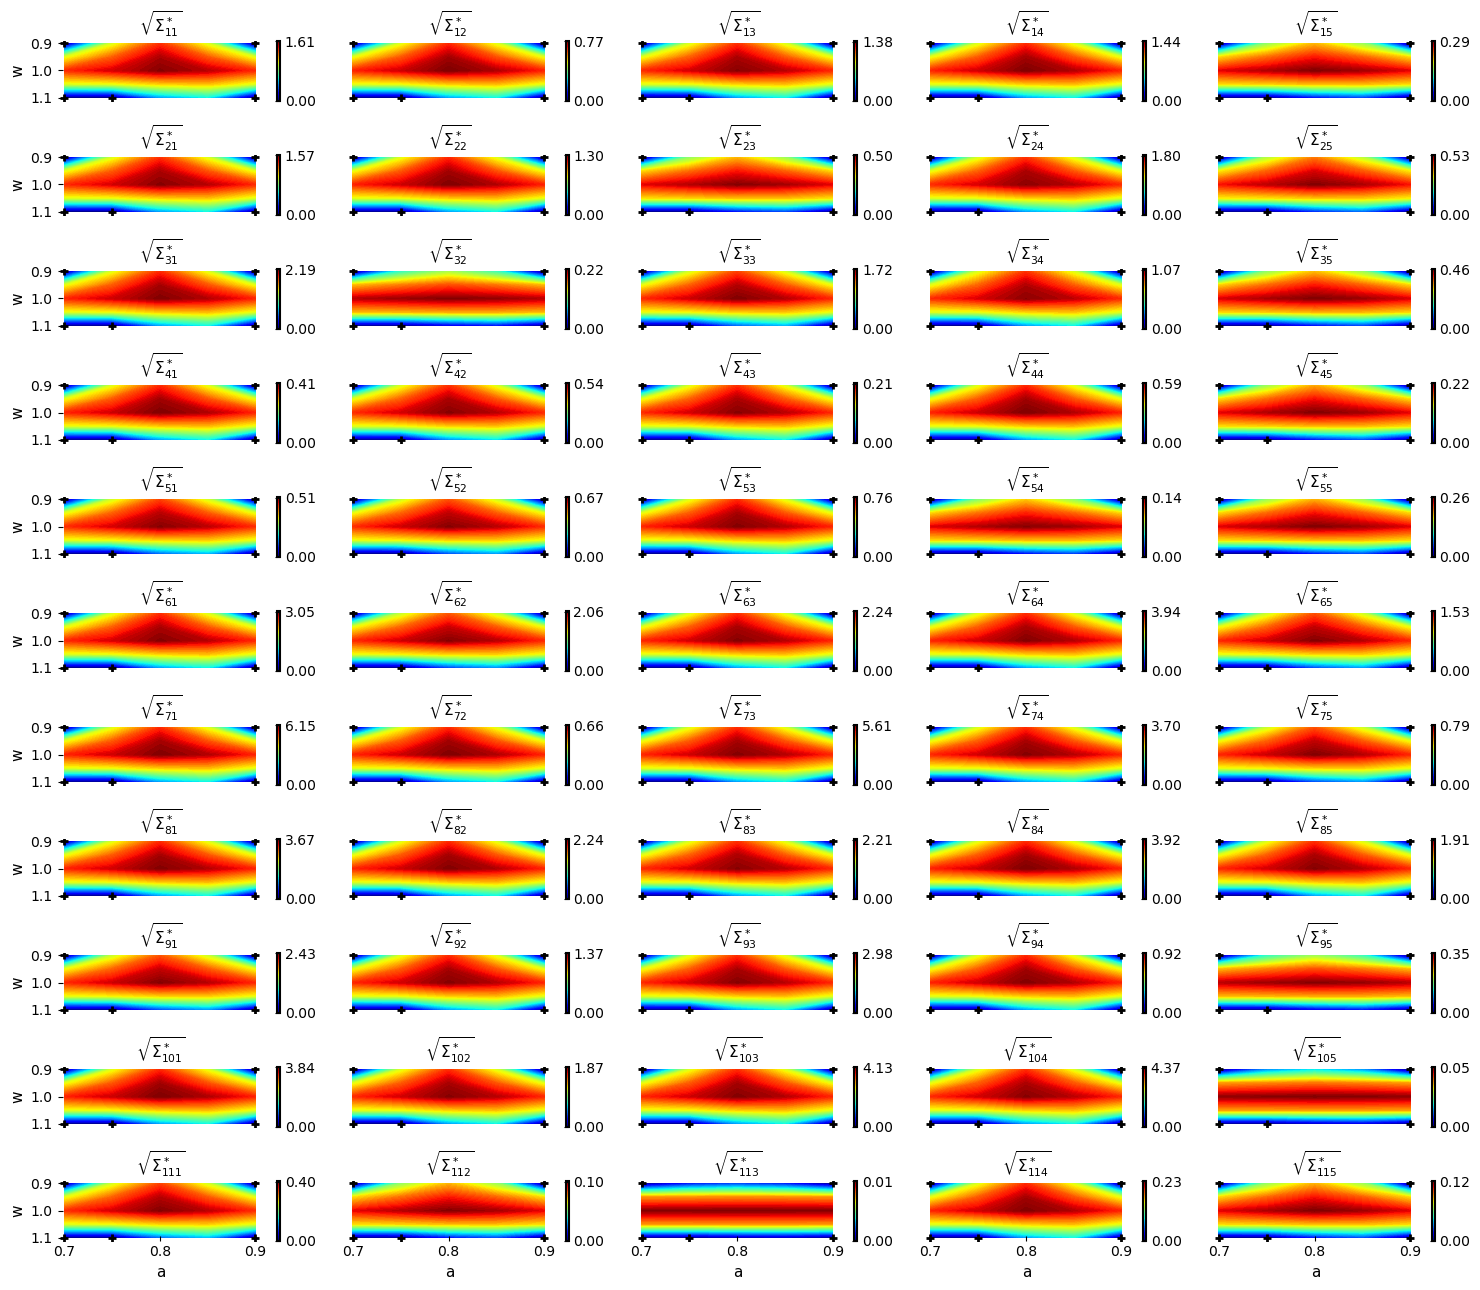

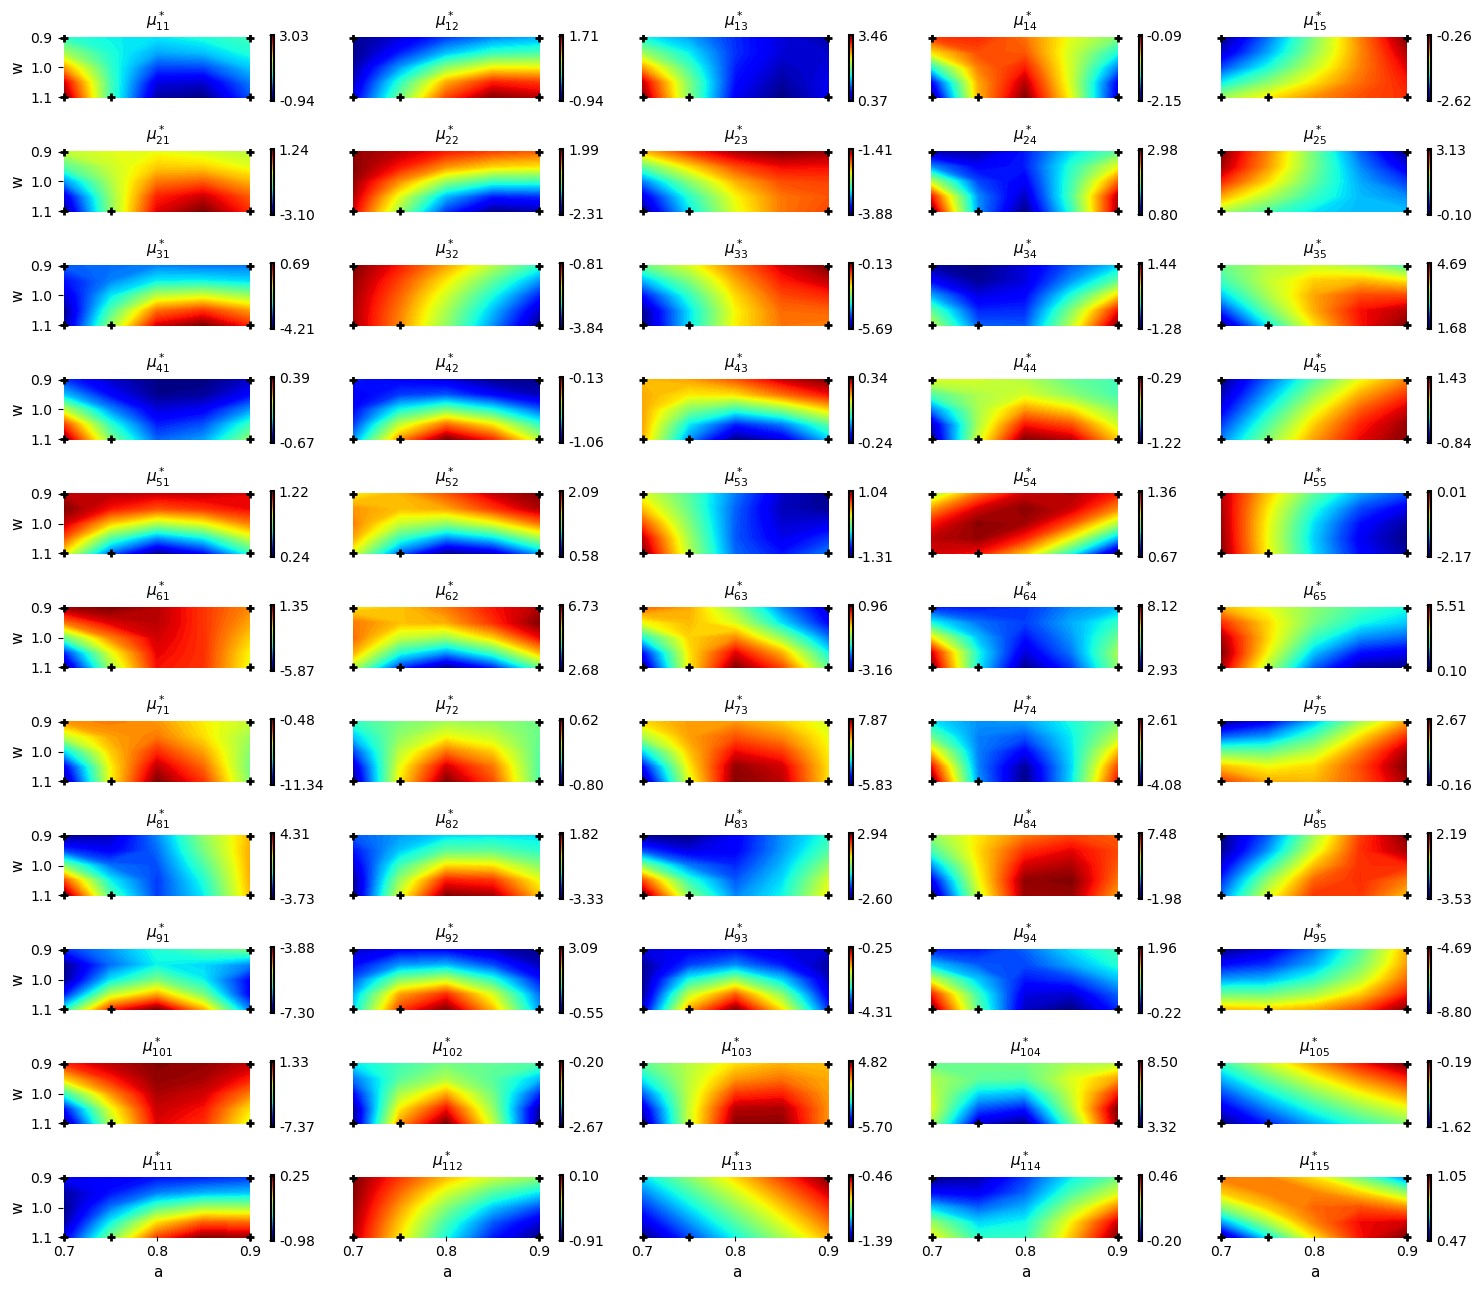

In [5]:
import  Plot;

if(n_p == 2):
    Plot.Plot_GP2d( p1_mesh     = test_meshgrid[0], 
                    p2_mesh     = test_meshgrid[1], 
                    gp_mean     = gp_pred_mean, 
                    gp_std      = gp_pred_std, 
                    param_train = param_train, 
                    param_names = param_names, 
                    n_cols      = 5);

13:22:03.540 - Plot:Plot_Heatmap2d:636 - INFO - Making heatmap. Parameters = ['a', 'w']. There are 5 training points (4 initial) and 25 testing points.
13:22:03.540 - Plot:Plot_Heatmap2d:636 - INFO - Making heatmap. Parameters = ['a', 'w']. There are 5 training points (4 initial) and 25 testing points.


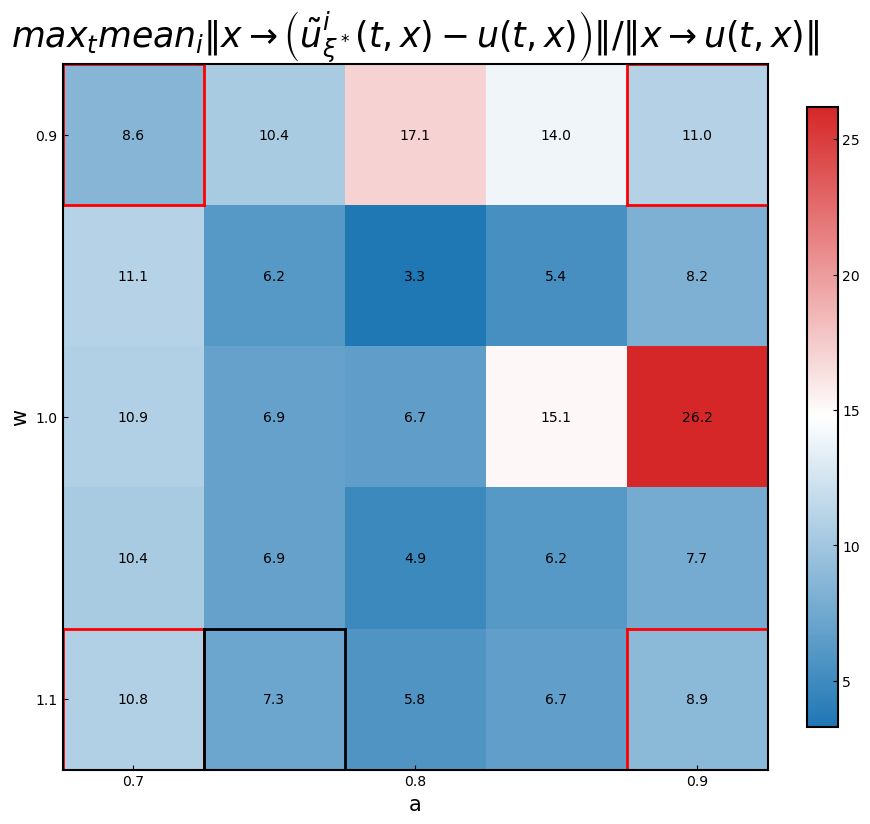

13:22:03.786 - Plot:Plot_Heatmap2d:636 - INFO - Making heatmap. Parameters = ['a', 'w']. There are 5 training points (4 initial) and 25 testing points.
13:22:03.786 - Plot:Plot_Heatmap2d:636 - INFO - Making heatmap. Parameters = ['a', 'w']. There are 5 training points (4 initial) and 25 testing points.


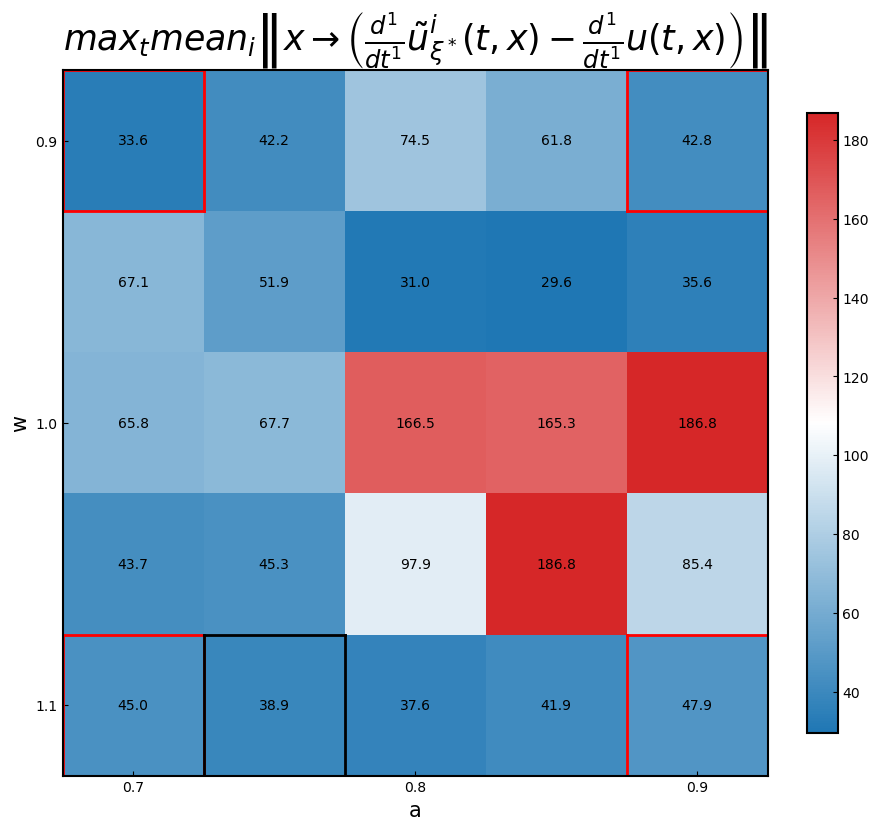

In [6]:
for d in range(n_IC):
    if(d == 0):
        title_string : str = r'$max_{t} mean_{i} \|x \to \left(\tilde{u}_{\xi^*}^{i}(t, x) - u(t, x) \right) \|/\| x \to u(t, x)\|$';
    else:
        title_string : str = r'$max_{t} mean_{i} \left\|x \to \left( \frac{d^{%d}}{dt^{%d}}\tilde{u}_{\xi^*}^{i}(t, x) - \frac{d^{%d}}{dt^{%d}}u(t, x) \right) \right\|$' % (d, d, d, d);


    Plot.Plot_Heatmap2d(values          = mean_rel_error[d] * 100, 
                        p1_grid         = test_meshgrid[0][:, 0], 
                        p2_grid         = test_meshgrid[1][0, :], 
                        param_train     = param_train, 
                        n_init_train    = param_space.n_init_train, 
                        param_names     = param_names, 
                        title           = title_string);

13:22:13.156 - Plot:Plot_Heatmap2d:636 - INFO - Making heatmap. Parameters = ['a', 'w']. There are 5 training points (4 initial) and 25 testing points.
13:22:13.156 - Plot:Plot_Heatmap2d:636 - INFO - Making heatmap. Parameters = ['a', 'w']. There are 5 training points (4 initial) and 25 testing points.


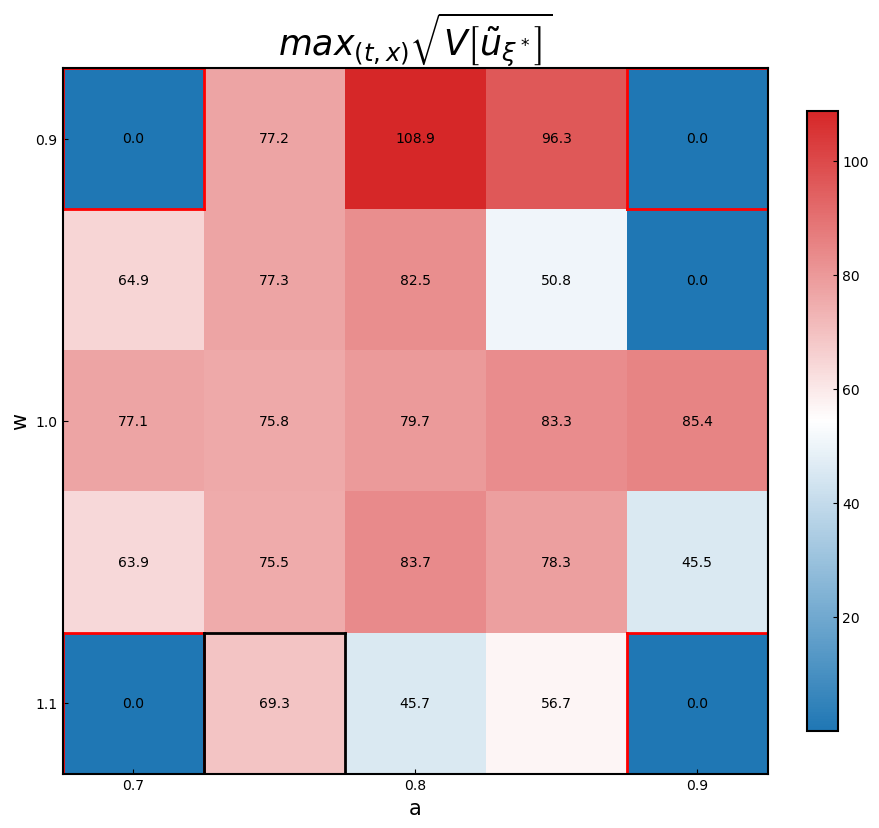

13:22:13.262 - Plot:Plot_Heatmap2d:636 - INFO - Making heatmap. Parameters = ['a', 'w']. There are 5 training points (4 initial) and 25 testing points.
13:22:13.262 - Plot:Plot_Heatmap2d:636 - INFO - Making heatmap. Parameters = ['a', 'w']. There are 5 training points (4 initial) and 25 testing points.


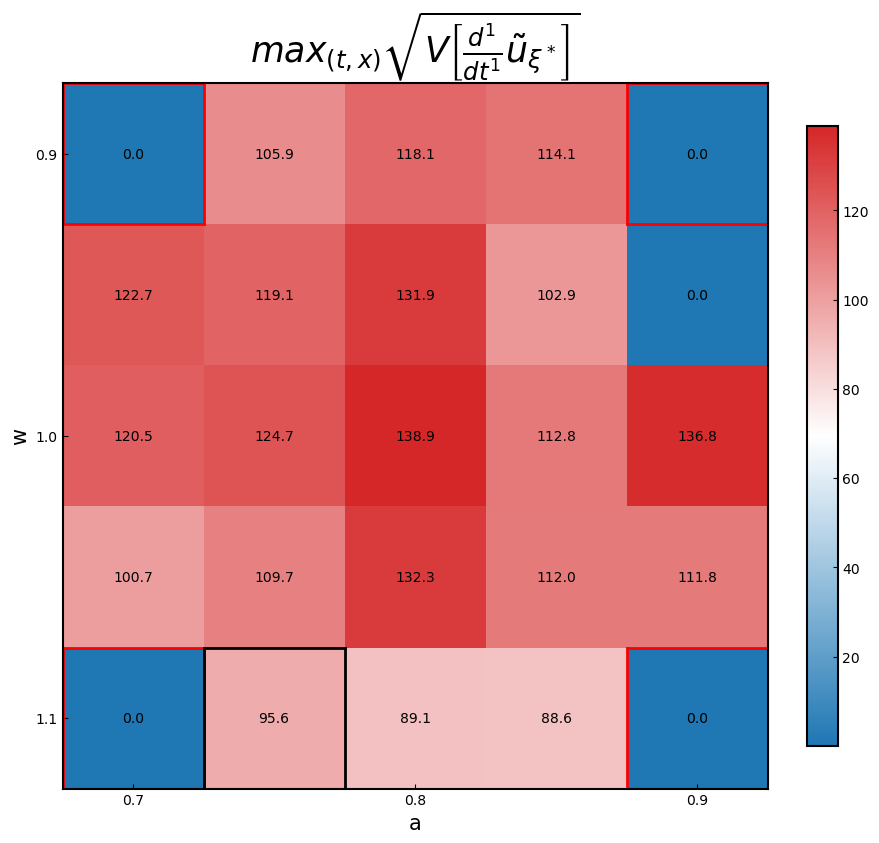

In [7]:
import Plot; 

for d in range(n_IC):
    if(d == 0):
        title : str = r'$max_{(t, x)} \sqrt{ V \left[ \tilde{u}_{\xi^*} \right] }$';
    else:
        title : str = r'$max_{(t, x)} \sqrt{ V \left[\frac{d^{%d}}{dt^{%d}}\tilde{u}_{\xi^*} \right] }$' % (d, d);


    Plot.Plot_Heatmap2d(values          = max_std[d] * 100, 
                        p1_grid         = test_meshgrid[0][:, 0], 
                        p2_grid         = test_meshgrid[1][0, :], 
                        param_train     = param_train, 
                        n_init_train    = param_space.n_init_train, 
                        param_names     = param_names, 
                        title           = title);

In [14]:
import importlib
importlib.reload(Plot);
# Pick some parameter values.
a           : float                 = 0.9;
w           : float                 = 1.07; 
param_grid  : numpy.ndarray         = numpy.array([[a, w]]);

# Get the predicted solution using this parameter value.
X_True      : list[torch.Tensor]    = physics.solve(param_grid[0]);
for d in range(n_IC):
    X_True[d] = X_True[d].detach().squeeze().numpy();

# Plot the predictions!
Plot.Plot_Prediction(
            model           = model, 
            physics         = physics, 
            latent_dynamics = latent_dynamics, 
            param_grid      = param_grid,
            gp_list         = gp_list, 
            n_samples       = n_samples, 
            X_True          = X_True);


/Users/stephany1/miniconda3/envs/LaSDI/lib/python3.10/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


AttributeError: 'list' object has no attribute 'detach'